In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchtext
import torchtext.transforms as T
from torch.utils.data import DataLoader
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.schemas import NlpContext
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.text import build_vocab, is_longer_text
from torchlake.sequence_data.models.lstm import LSTMDiscriminator
from torchlake.text_classification.datasets.ag_news import CLASS_NAMES
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import AG_NEWS

In [2]:
torch.__version__

'2.1.0+cu118'

In [3]:
torchtext.__version__

'0.16.0+cpu'

# setting


In [4]:
batch_size = 512
context = NlpContext()

In [5]:
tokenizer = get_tokenizer("basic_english")

In [6]:
artifact_path = Path("../../artifacts/lstm")
dataset_path = Path("../../data/AGNews")

In [7]:
DEVICE = torch.device(context.device)

# dataset


In [8]:
NUM_CLASS = len(CLASS_NAMES)

In [9]:
MINIMUM_LENGTH = 5

In [10]:
def datapipe_factory(
    datapipe,
    minimum_length: int = 1,
    transform=None,
):
    datapipe = (
        datapipe
            .map(lambda pair: (pair[1], pair[0])) # label, text -> text, label
            .map(lambda pair: (pair[0], pair[1]-1))
            .map(lambda pair: (pair[0].strip(), pair[1]))
            .map(lambda pair: (pair[0].lower(), pair[1]))
            .filter(lambda pair: is_longer_text(pair[0], minimum_length))
            .map(
                lambda pair: (tokenizer(pair[0]), pair[1])
            )
    )

    if transform:
        datapipe = datapipe.map(lambda item: (transform(item[0]), item[1]))

    return datapipe

In [11]:
train_datapipe, test_datapipe = AG_NEWS(dataset_path.as_posix())

In [12]:
vocab = build_vocab(map(lambda x: x[0], datapipe_factory(train_datapipe)))

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [13]:
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

30335

In [14]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    # T.Truncate(context.max_seq_len - 2),
    # T.AddToken(token=context.bos_idx, begin=True),
    # T.AddToken(token=context.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(context.max_seq_len, context.padding_idx),
)

In [15]:
train_datapipe = datapipe_factory(
    train_datapipe,
    minimum_length=MINIMUM_LENGTH,
    transform=text_transform,
)

test_datapipe = datapipe_factory(
    test_datapipe,
    minimum_length=MINIMUM_LENGTH,
    transform=text_transform,
)

In [16]:
for text, label in train_datapipe:
    print(text.shape)
    print(label)
    break

torch.Size([256])
2


In [17]:
NUM_WORKERS = get_num_workers()

In [18]:
def collate_fn(batch: list):
    text_placeholder, label_placeholder = [], []
    for text, label in batch:
        text_placeholder.append(text)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.LongTensor(label_placeholder)

In [19]:
train_dataloader = DataLoader(
    train_datapipe,
    batch_size=batch_size,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_datapipe,
    batch_size=batch_size,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
)

In [20]:
for text, label in train_dataloader:
    print(text.shape, label.shape)
    break

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


torch.Size([512, 256]) torch.Size([512])


# model


In [21]:
embed_dim = 300
hidden_dim = 256
model = LSTMDiscriminator(
    VOCAB_SIZE,
    embed_dim,
    hidden_dim,
    NUM_CLASS,
    num_layers=1,
    context=context,
).to(DEVICE)

In [22]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
LSTMDiscriminator                        --
├─Embedding: 1-1                         9,100,500
├─LSTM: 1-2                              571,392
├─LayerNorm: 1-3                         512
├─Linear: 1-4                            1,028
Total params: 9,673,432
Trainable params: 9,673,432
Non-trainable params: 0

In [23]:
EPOCHS = 10

In [24]:
trainer = ClassificationTrainer(EPOCHS, DEVICE)

In [25]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(model.parameters())

In [26]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [27]:
training_loss = trainer.run(train_dataloader, model, optimizer, criterion, scheduler)

235it [00:29,  7.89it/s]


epoch 1 : 0.30111305510744135


235it [00:28,  8.18it/s]


epoch 2 : 0.14173404216132265


235it [00:30,  7.76it/s]


epoch 3 : 0.10548615628417501


235it [00:31,  7.55it/s]


epoch 4 : 0.08205643805100563


235it [00:29,  8.05it/s]


epoch 5 : 0.06504820684327724


235it [00:30,  7.81it/s]


epoch 6 : 0.049443615862029666


235it [00:31,  7.36it/s]


epoch 7 : 0.03934327516149967


235it [00:29,  7.85it/s]


epoch 8 : 0.030338133166128017


235it [00:31,  7.53it/s]


epoch 9 : 0.022006388081911396


235it [00:30,  7.66it/s]

epoch 10 : 0.01783214765501783


[0.30111305510744135,
 0.14173404216132265,
 0.10548615628417501,
 0.08205643805100563,
 0.06504820684327724,
 0.049443615862029666,
 0.03934327516149967,
 0.030338133166128017,
 0.022006388081911396,
 0.01783214765501783]

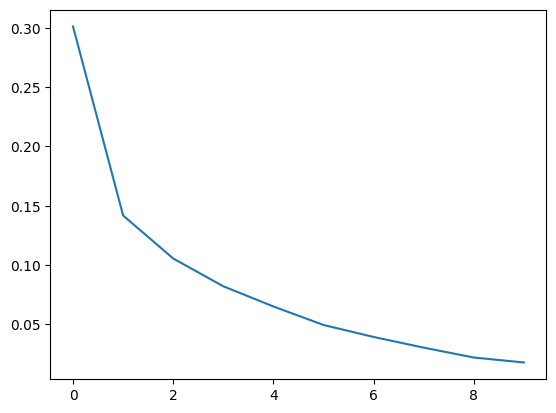

In [30]:
plt.plot(training_loss)

# inference


In [28]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE)

In [37]:
confusion_matrix = evaluator.run(test_dataloader, model)

15it [00:02,  5.85it/s]

[[1730   52   58   60]
 [  29 1851   19    1]
 [  84   18 1648  150]
 [  50   29  127 1694]]


In [38]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(CLASS_NAMES , per_class_acc)

world     : 0.9105263157894737
sports    : 0.9742105263157895
business  : 0.8673684210526316
science   : 0.891578947368421


In [39]:
per_class_acc.mean()

0.910921052631579

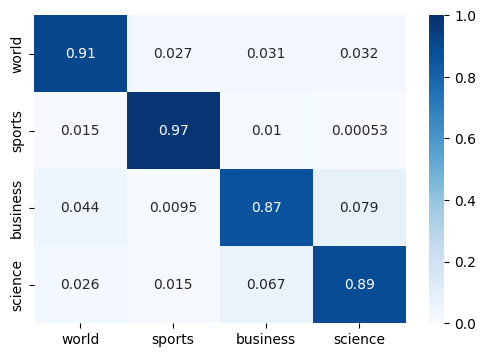

In [40]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    CLASS_NAMES,
    "Blues",
    annot=True,
    figsize=(6, 4),
)

In [31]:
model_path = artifact_path.joinpath("lstm.pth")

In [32]:
torch.save(model.state_dict(), model_path)

In [33]:
get_file_size(model_path)

'36.9MiB'

In [34]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>